In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


# Women's Clothing E-Commerce Reviews - Linear Regression from Scratch

# --- 1. Load and Preprocessing Data ---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore')

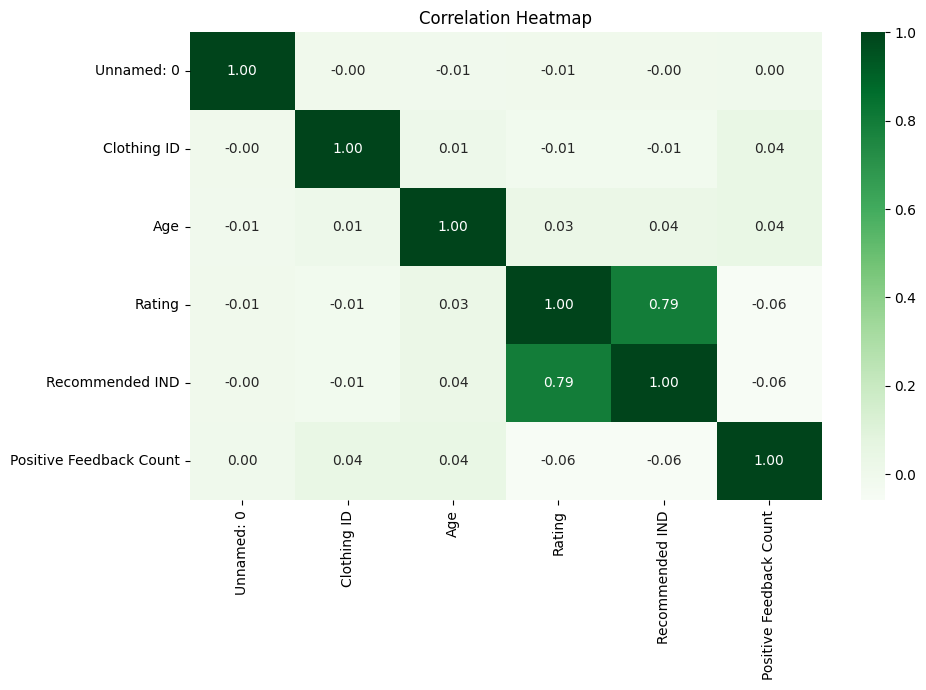

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")
df.dropna(inplace=True)

# Drop all string (object) columns
df = df.select_dtypes(include=[np.number])

# Drop columns with zero variance
df = df.loc[:, df.std() != 0]

# 🔥 Heatmap: Correlation between numerical features
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap="Greens", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# --- 2. Visualizations ---

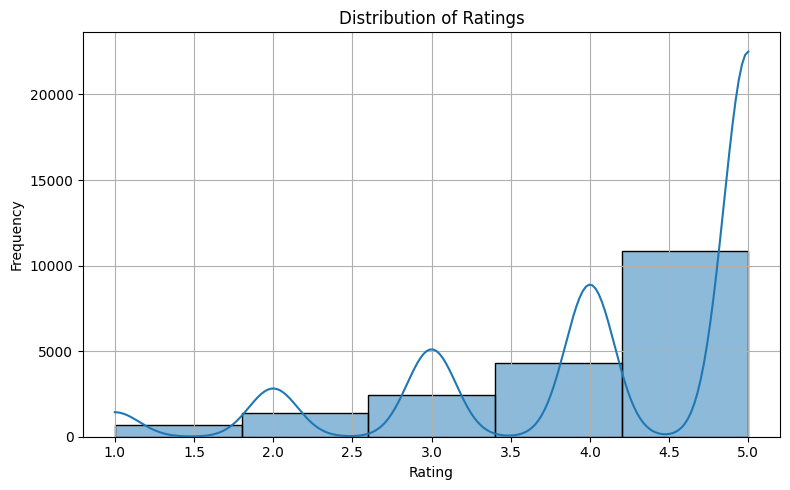

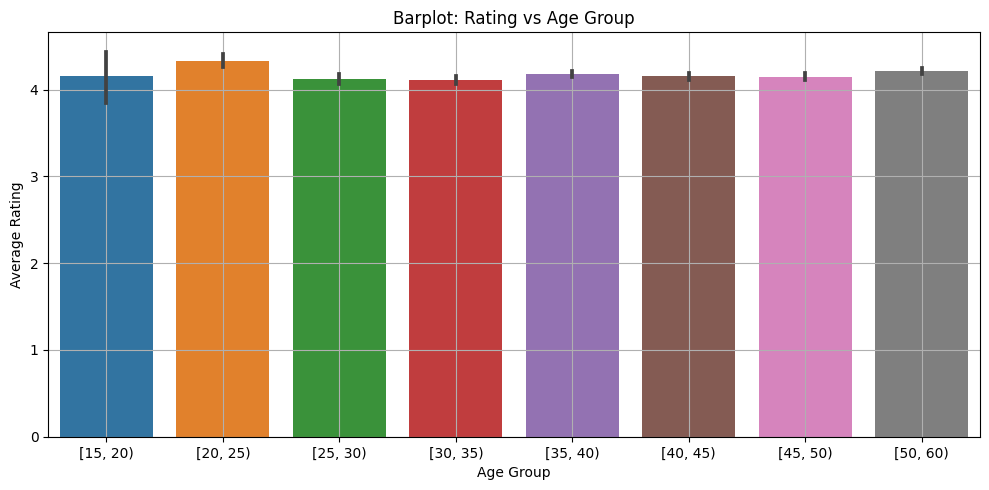

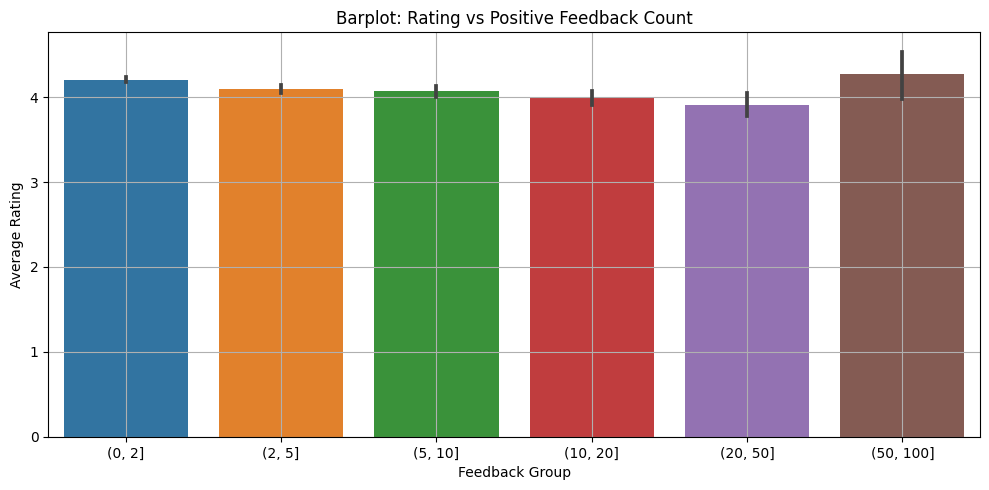

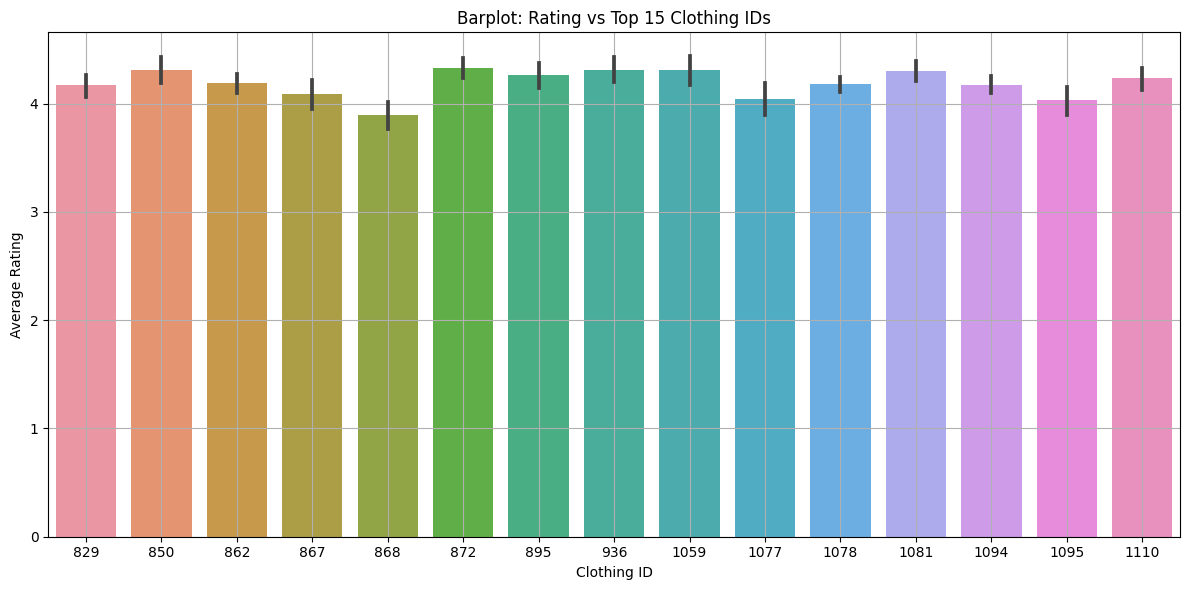

In [4]:
# Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df["Rating"], bins=5, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Age vs Rating (grouped)
df['AgeGroup'] = pd.cut(df['Age'], bins=[15, 20, 25, 30, 35, 40, 45, 50, 60], right=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='AgeGroup', y='Rating')
plt.title("Barplot: Rating vs Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.grid(True)
plt.show()

# Positive Feedback Count (grouped)
df['FeedbackGroup'] = pd.cut(df['Positive Feedback Count'], bins=[0, 2, 5, 10, 20, 50, 100])
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='FeedbackGroup', y='Rating')
plt.title("Barplot: Rating vs Positive Feedback Count")
plt.xlabel("Feedback Group")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.grid(True)
plt.show()

# Clothing ID (Top 15 only)
top_clothing_ids = df['Clothing ID'].value_counts().head(15).index
df_top = df[df['Clothing ID'].isin(top_clothing_ids)]
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='Clothing ID', y='Rating')
plt.title("Barplot: Rating vs Top 15 Clothing IDs")
plt.xlabel("Clothing ID")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.grid(True)
plt.show()

# --- 3. Prepare Data ---

In [8]:
X = df.drop(columns=["Rating", "AgeGroup", "FeedbackGroup"], errors='ignore')
y = df["Rating"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=19)

# --- 4. Linear Regression from Scratch ---


In [9]:
class LinearRegressionScratch:
    def __init__(self, lr=0.01, n_iters=200, regularization=None, lambda_=0.01, use_sgd=False):
        self.lr = lr
        self.n_iters = n_iters
        self.regularization = regularization
        self.lambda_ = lambda_
        self.use_sgd = use_sgd
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.n_iters):
            if self.use_sgd:
                indices = np.random.permutation(n_samples)
                total_loss = 0
                for i in indices:
                    xi = X[i].reshape(1, -1)
                    yi = y[i]
                    y_pred = np.dot(xi, self.weights) + self.bias
                    error = y_pred - yi

                    dw = xi.T * error
                    db = error

                    if self.regularization == "ridge":
                        dw += self.lambda_ * self.weights.reshape(-1, 1)

                    self.weights -= self.lr * dw.flatten()
                    self.bias -= self.lr * db

                    total_loss += error ** 2

                self.losses.append(total_loss / n_samples)

            else:
                y_pred = np.dot(X, self.weights) + self.bias
                error = y_pred - y

                dw = (1 / n_samples) * np.dot(X.T, error)
                db = (1 / n_samples) * np.sum(error)

                if self.regularization == "ridge":
                    dw += self.lambda_ * self.weights

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

                loss = np.mean(error ** 2)
                self.losses.append(loss)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# --- 5. Train Models ---


In [10]:
model_batch = LinearRegressionScratch(lr=0.01, n_iters=200)
model_batch.fit(X_train, y_train)
y_pred_batch = model_batch.predict(X_test)

model_ridge = LinearRegressionScratch(lr=0.01, n_iters=200, regularization="ridge", lambda_=0.1)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

model_sgd = LinearRegressionScratch(lr=0.01, n_iters=200, use_sgd=True)
model_sgd.fit(X_train, y_train)
y_pred_sgd = model_sgd.predict(X_test)

# --- 6. Combined Loss Plot ---


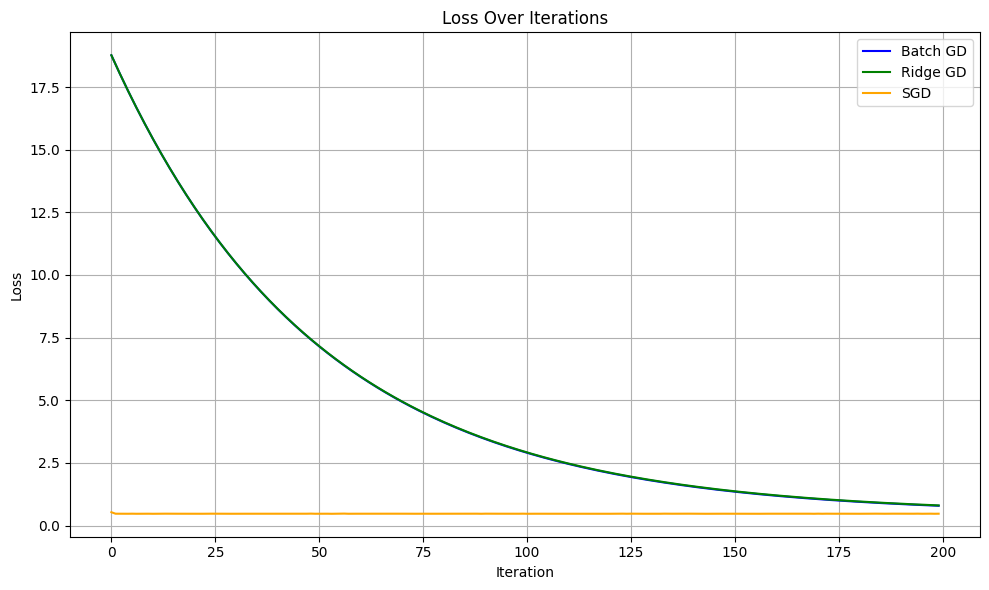

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(model_batch.losses, label="Batch GD", color="blue")
plt.plot(model_ridge.losses, label="Ridge GD", color="green")
plt.plot(model_sgd.losses, label="SGD", color="orange")
plt.title("Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Evaluate Models ---


In [12]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} - MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"{name} - R2 Score: {r2_score(y_true, y_pred):.4f}")
    print("-----")

evaluate_model("Batch GD", y_test, y_pred_batch)
evaluate_model("Ridge GD", y_test, y_pred_ridge)
evaluate_model("SGD", y_test, y_pred_sgd)


Batch GD - MSE: 0.7957
Batch GD - R2 Score: 0.3684
-----
Ridge GD - MSE: 0.8082
Ridge GD - R2 Score: 0.3585
-----
SGD - MSE: 0.4881
SGD - R2 Score: 0.6126
-----


# --- 8. Plot Predictions ---


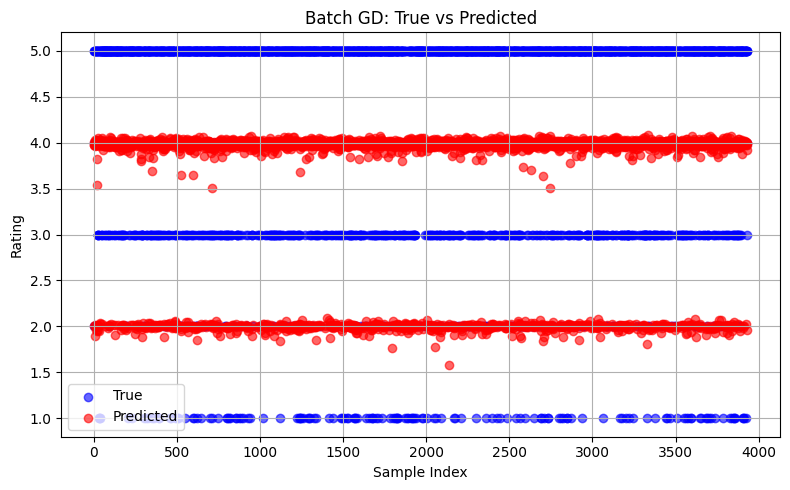

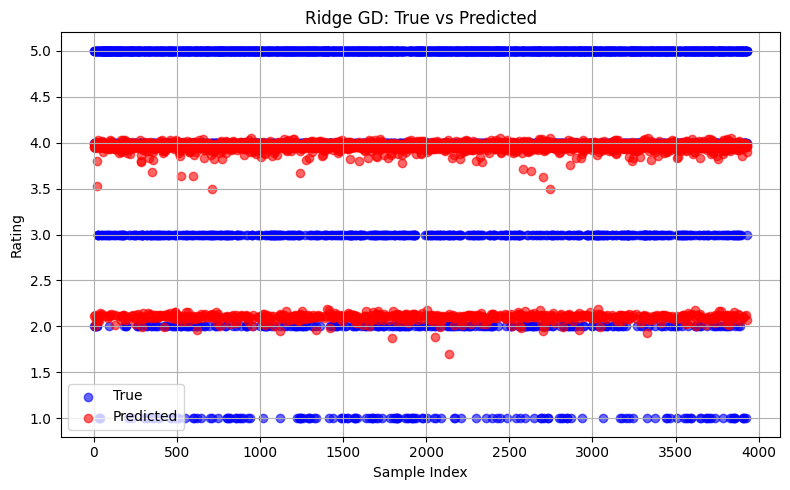

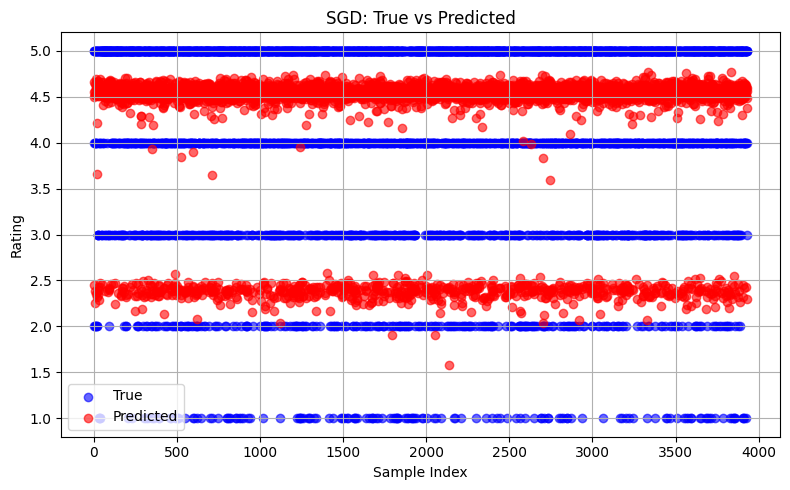

In [13]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(y_true)), y_true, color='blue', label='True', alpha=0.6)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.6)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Rating")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_test, y_pred_batch, "Batch GD: True vs Predicted")
plot_predictions(y_test, y_pred_ridge, "Ridge GD: True vs Predicted")
plot_predictions(y_test, y_pred_sgd, "SGD: True vs Predicted")


# --- Thank You ---
